In [44]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,scale
import pandas as pd

%matplotlib inline

In [45]:
def get_data(size):
    ratings = []
    if size == "100k":
        path = "../dat/rec/ml-100k/u.data"
        print("Read movie lens 100k data set")
        f = open(path, "r")
        while (1):
            line = f.readline()
            if line == "":
                break
            ratings.append(line.split()[0:-1])
        f.close()
    ratings = np.array(ratings, dtype = np.float32)
    # permute the ratings array
    ratings = np.random.permutation(ratings)
    print("Loading data done")
    return ratings

In [46]:
ratings = get_data("100k")

Read movie lens 100k data set
Loading data done


In [47]:
ratings.shape

(100000, 3)

In [48]:
def load_split_data(data_size, test_p):
    # Load data and split into train set, test set randomly.
    # data_size is either "100k", "1m", "10m" or "20m".
    # test_p is a float between 0 - 1 indicating the portion of data hold out as test set
    print("split data randomly")
    # Load ratings, data is already permuted in get_data
    ratings = get_data(data_size)
    nb_users = int(np.max(ratings[:, 0]))
    nb_movies = int(np.max(ratings[:, 1]))
    # split test/train set
    test_size = int(len(ratings) * test_p)
    test_ratings = ratings[:test_size]
    train_ratings = ratings[test_size:]
    # train_ratings is converted into a matrix
    train_M = np.zeros((nb_movies, nb_users), dtype = np.float32)
    for rating in train_ratings:
        train_M[int(rating[1]-1), int(rating[0]-1)] = rating[2]
    # save test and train data in case more training is needed on this split
    np.save("../dat/rec/" + data_size + "_" + str(int(test_p * 100))+ "percent_test.npy", test_ratings)
    np.save("../dat/rec/" + data_size + "_" + str(int(test_p * 100))+ "percent_trainM.npy", train_M)
    # test_ratings is numpy array of user id | item id | rating
    # train_M is numpy array with nb_movies rows and nb_users columns, missing entries are filled with zero
    return test_ratings, train_M, nb_users, nb_movies, len(train_ratings)


In [49]:
# def cal_RMSE(prediction_M, test_ratings):
#     RMSE = 0
#     for rating in test_ratings:
#         RMSE += (rating[2] - prediction_M[int(rating[1] - 1), int(rating[0] - 1)])**2
#     RMSE = math.sqrt(RMSE / len(test_ratings))
#     return RMSE

In [61]:
np.random.seed(0)
nb_epoch = 2000
test_p = 0.1
nb_hunits = 4
lambda_reg = 0.001
epsilon = 1e-4 #learningrate
reg_lambda = 0.01
data_size = "100k"
test_ratings, train_M, nb_users, nb_movies, k = load_split_data(data_size, test_p)
prediction_M = np.zeros((nb_movies, nb_users), dtype = np.float32) # 1682 x 943
RMSE_list = [0] * nb_epoch # 1 x 10
L = []

split data randomly
Read movie lens 100k data set
Loading data done


In [62]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [63]:
def train(X, X_observed, update_matrix):

    W1 = np.random.randn(nb_users, nb_hunits) # 943 x 10
    b1 = np.zeros((1, nb_hunits)) # 1 x 10
    W2 = np.random.randn(nb_hunits, nb_users) # 10 x 943
    b2 = np.zeros((1, nb_users)) # 1 x 943
    a2 = np.zeros((nb_movies, nb_users)) # 1682 x 943
    
    for i in range(0, nb_epoch):

        z1 = X.dot(W1) + b1 # 1682x943 dot 943x10
        a1 = sigmoid(z1) # 1682x10
        z2 = a1.dot(W2) + b2 #1682x10 dot 10x943
#         a2 = sigmoid(z2) #1682x943
        a2 = z2
        tmp1 = np.sum(np.square(W1))
        tmp2 = np.sum(np.square(W2))
        loss_reg = (1.0/nb_movies) * (lambda_reg/2) * ( tmp1 + tmp2 )
        loss = np.sum( np.square((X - a2) * X_observed) ) + loss_reg
        L.append(loss)
        if i % 500 == 0:
            print("Round: " + str(i) + ", Loss: "+ str(loss))

        # Backpropagation
#         delta2 = (a2 * (1 - a2)) * (a2 - X) # 1682x943
        delta2 = (a2 - X)*X_observed
        dW2 = (a1.T).dot(delta2) # 10x943
        db2 = np.sum(delta2, axis=0, keepdims=True) # 1x943
        delta1 = (a1 * (1 - a1)) * (delta2.dot(W2.T)) # 1682x943
        dW1 = ((X*X_observed).T).dot(delta1) # 943x10
        db1 = np.sum(delta1, axis=0) # 1x10
        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        # Gradient descent parameter update
        # original: 943x10 * 943x10
        W1 += -epsilon * dW1# 943x1682 * 943x10
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
    return a2

In [64]:
def train_auto():
        
    Ri = train_M[:] # (1682, 943)
    Ri_observed = Ri.copy()
    Ri_observed[Ri > 0] = 1 # (1682, 943)
    update_m = Ri_observed # 
    Ri_predicted = train(Ri, Ri_observed, update_m)
    prediction_M = Ri_predicted
#         RMSE_list[j] = cal_RMSE(prediction_M, test_ratings)
    print("training complete")
    return train_M, prediction_M

In [65]:
train_M, prediction_M = train_auto()

Round: 0, Loss: 1525901.70636
Round: 500, Loss: 94452.6852551
Round: 1000, Loss: 91232.1098081
Round: 1500, Loss: 89328.5309267
training complete


In [58]:
prediction_M

array([[ 3.7913515 ,  3.76357883,  2.95237886, ...,  4.24114332,
         4.35289348,  3.49742731],
       [ 3.7913515 ,  3.76357883,  2.95237886, ...,  4.24114332,
         4.35289348,  3.49742731],
       [ 3.7913515 ,  3.76357883,  2.95237886, ...,  4.24114332,
         4.35289348,  3.49742731],
       ..., 
       [ 1.46800371,  2.05829461,  1.49963204, ...,  2.38735159,
         2.28162915,  2.04543165],
       [ 0.98583165,  2.00577766,  2.53915806, ...,  2.24333677,
         2.454226  ,  2.53266019],
       [ 0.42221571,  2.12562729,  0.92784702, ...,  2.74212846,
         2.28781551,  2.32144802]])

In [59]:
train_M

array([[ 5.,  4.,  0., ...,  0.,  0.,  0.],
       [ 3.,  0.,  0., ...,  0.,  0.,  5.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

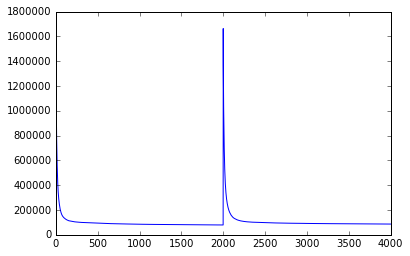

In [60]:
plt.plot(L)

In [ ]:
# np.tile(np.array([2,1]), 3) # stands for repeat
# t = np.tile(np.array([2,1]), [10, 1])
# t2 = t.copy()
# t2[t == 1] = 52

In [49]:
# a = np.array([[2,1], [10, 1]])#2,2
# b = np.array([[3,4],[4, 4])#2,1
# a * b